In [1]:
import os
import sys
sys.path.append("../")
import csv
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import parse_ficocianina_xls

import settings

In [4]:
ndci_data_path = os.path.join(settings.final_data_path, "kmeans_3", "ndci_data.csv")
precipitation_data_path = os.path.join(settings.final_data_path, "precipitation", "precipitation.csv")
wind_data_path = os.path.join(settings.final_data_path, "wind_data.csv")
water_temperature_data_path = os.path.join(settings.final_data_path, "water_temperature.csv")
algae_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")
ta_ose_path = os.path.join(settings.final_data_path, "agua_open_data(1).csv")
s3_brrs_path = os.path.join(settings.final_data_path, "s3_brrs.json")

raw_cyano_gt_path = os.path.join(settings.final_data_path, "MUESTREOS_SEMANALES_2016-2017-2018-2019-2020.xls")
raw_cyano_gt_path_new = os.path.join(settings.final_data_path, "validation", "MUESTREOS 2022-2023.xls")

bloom_thresholds = {
                    "MALLORQUINA":7000,
                    "ARROYO SAUCE": 7000,
                    "SAUCE NORTE": 7000,
                    "SAUCE SUR": 7000,
                    "CISNES": 7000,
                    "POTRERO": 7000,
                    "TA":3000
                   }

### Read and clean ground truth xls

In [12]:
sample_locations = ["MALLORQUINA", "ARROYO SAUCE", "SAUCE NORTE", "SAUCE SUR", "CISNES", "POTRERO"]

algae_gt_df = parse_ficocianina_xls(raw_cyano_gt_path, sample_locations)

# add extra data from different csv
ta_ose_df = pd.read_csv(ta_ose_path)
ta_ose_df["Fecha"] = pd.to_datetime(ta_ose_df['Fecha']).dt.date
ta_ose_df.rename({"Estación": "location"}, axis=1, inplace=True)
ta_ose_df.rename({"Fecha": "date"}, axis=1, inplace=True)
ta_ose_df.rename({"Cianobacterias_Total (cel.eq) (cel.eq/ml)": "fico"}, axis=1, inplace=True)

dates_1 = algae_gt_df["date"].unique()
dates_2 = ta_ose_df["date"].unique()
missing_dates = sorted(list(set(dates_2) - set(dates_1)))
#ta_ose_df = ta_ose_df[ta_ose_df["date"].isin(missing_dates)]
ta_ose_df["chl"] = np.nan

algae_gt_df = pd.concat([algae_gt_df, ta_ose_df], ignore_index=True)
algae_gt_df = algae_gt_df.sort_values(by='date',ascending=True)
algae_gt_df

          date      location     fico
0   2015-12-30   MALLORQUINA   5032.5
1   2015-12-30  ARROYO SAUCE   5345.5
2   2015-12-30   SAUCE NORTE   4282.5
3   2015-12-30     SAUCE SUR   5388.0
4   2015-12-30        CISNES   9082.5
..         ...           ...      ...
518 2020-05-10  ARROYO SAUCE   1294.5
519 2020-05-10   SAUCE NORTE  27936.5
520 2020-05-10     SAUCE SUR  31632.5
521 2020-05-10        CISNES   4470.5
522 2020-05-10       POTRERO   1788.5

[523 rows x 3 columns]
          date      location    chl
0   2015-12-30   MALLORQUINA  10.00
1   2015-12-30  ARROYO SAUCE  21.80
2   2015-12-30   SAUCE NORTE   7.50
3   2015-12-30     SAUCE SUR   7.50
4   2015-12-30        CISNES  18.45
..         ...           ...    ...
518 2020-05-10  ARROYO SAUCE   3.35
519 2020-05-10   SAUCE NORTE   8.25
520 2020-05-10     SAUCE SUR   7.65
521 2020-05-10        CISNES   4.80
522 2020-05-10       POTRERO   4.15

[523 rows x 3 columns]


,date,location,fico,chl
0,2015-12-30,MALLORQUINA,5032.50,10.00
1,2015-12-30,ARROYO SAUCE,5345.50,21.80
2,2015-12-30,SAUCE NORTE,4282.50,7.50
3,2015-12-30,SAUCE SUR,5388.00,7.50
4,2015-12-30,CISNES,9082.50,18.45
...,...,...,...,...
685,2020-10-31,TA,1083.00,NaN
686,2020-11-01,TA,47.00,NaN
687,2020-11-02,TA,5.96,NaN
688,2020-11-05,TA,9.06,NaN


### Add labels

In [13]:
labels = []
for i, row in algae_gt_df.iterrows():
    if row["fico"] >= bloom_thresholds[row["location"]]:
        labels.append("Bloom")
    else:
        labels.append("No Bloom")
algae_gt_df["label"] = labels
algae_gt_df

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.50,10.00,No Bloom
1,2015-12-30,ARROYO SAUCE,5345.50,21.80,No Bloom
2,2015-12-30,SAUCE NORTE,4282.50,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.00,7.50,No Bloom
4,2015-12-30,CISNES,9082.50,18.45,Bloom
...,...,...,...,...,...
685,2020-10-31,TA,1083.00,NaN,No Bloom
686,2020-11-01,TA,47.00,NaN,No Bloom
687,2020-11-02,TA,5.96,NaN,No Bloom
688,2020-11-05,TA,9.06,NaN,No Bloom


## Process newer algae GT

In [10]:
sample_locations_new = ["ARROYO SAUCE", "MALLORQUINA", "SAUCE NORTE", "SAUCE SUR", "CISNES", "POTRERO"]

algae_gt_df_new = parse_ficocianina_xls(raw_cyano_gt_path_new, sample_locations_new)
labels_new = []
for i, row in algae_gt_df_new.iterrows():
    if row["fico"] >= bloom_thresholds[row["location"]]:
        labels_new.append("Bloom")
    else:
        labels_new.append("No Bloom")
algae_gt_df_new["label"] = labels_new
algae_gt_df_new

          date      location    fico
0   2022-06-23  ARROYO SAUCE   740.0
1   2022-06-23   MALLORQUINA   737.5
2   2022-06-23   SAUCE NORTE  1002.5
3   2022-06-23     SAUCE SUR   809.0
4   2022-06-23        CISNES   780.0
..         ...           ...     ...
119 2023-02-25   MALLORQUINA  1812.0
120 2023-02-25   SAUCE NORTE  1412.5
121 2023-02-25     SAUCE SUR  2002.5
122 2023-02-25        CISNES  1669.0
123 2023-02-25       POTRERO  2353.5

[124 rows x 3 columns]
          date      location   chl
0   2022-06-23  ARROYO SAUCE  4.90
1   2022-06-23   MALLORQUINA  4.05
2   2022-06-23   SAUCE NORTE  3.35
3   2022-06-23     SAUCE SUR  4.95
4   2022-06-23        CISNES  4.00
..         ...           ...   ...
119 2023-02-25   MALLORQUINA  3.80
120 2023-02-25   SAUCE NORTE  3.40
121 2023-02-25     SAUCE SUR  4.70
122 2023-02-25        CISNES  3.60
123 2023-02-25       POTRERO  3.90

[124 rows x 3 columns]


,date,location,fico,chl,label
0,2022-06-23,ARROYO SAUCE,740.0,4.90,No Bloom
1,2022-06-23,MALLORQUINA,737.5,4.05,No Bloom
2,2022-06-23,SAUCE NORTE,1002.5,3.35,No Bloom
3,2022-06-23,SAUCE SUR,809.0,4.95,No Bloom
4,2022-06-23,CISNES,780.0,4.00,No Bloom
...,...,...,...,...,...
119,2023-02-25,MALLORQUINA,1812.0,3.80,No Bloom
120,2023-02-25,SAUCE NORTE,1412.5,3.40,No Bloom
121,2023-02-25,SAUCE SUR,2002.5,4.70,No Bloom
122,2023-02-25,CISNES,1669.0,3.60,No Bloom


## Append to older one

In [14]:
final_algae_gt_df = algae_gt_df.append(algae_gt_df_new, ignore_index=True)
final_algae_gt_df

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.5,10.00,No Bloom
1,2015-12-30,ARROYO SAUCE,5345.5,21.80,No Bloom
2,2015-12-30,SAUCE NORTE,4282.5,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.0,7.50,No Bloom
4,2015-12-30,CISNES,9082.5,18.45,Bloom
...,...,...,...,...,...
809,2023-02-25,MALLORQUINA,1812.0,3.80,No Bloom
810,2023-02-25,SAUCE NORTE,1412.5,3.40,No Bloom
811,2023-02-25,SAUCE SUR,2002.5,4.70,No Bloom
812,2023-02-25,CISNES,1669.0,3.60,No Bloom


## Save as CSV

In [15]:
#final_algae_gt_df.to_csv(algae_gt_path, index=False)
#algae_gt_df.to_csv(algae_gt_path, index=False)

## Load csv with algae GT

In [16]:
algae_gt_df = pd.read_csv(algae_gt_path)
algae_gt_df["date"] = pd.to_datetime(algae_gt_df['date']).dt.date
algae_gt_df

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.5,10.00,No Bloom
1,2015-12-30,ARROYO SAUCE,5345.5,21.80,No Bloom
2,2015-12-30,SAUCE NORTE,4282.5,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.0,7.50,No Bloom
4,2015-12-30,CISNES,9082.5,18.45,Bloom
...,...,...,...,...,...
809,2023-02-25,MALLORQUINA,1812.0,3.80,No Bloom
810,2023-02-25,SAUCE NORTE,1412.5,3.40,No Bloom
811,2023-02-25,SAUCE SUR,2002.5,4.70,No Bloom
812,2023-02-25,CISNES,1669.0,3.60,No Bloom


### Dataset loading class

In [17]:
from prediction_dataset import PredictionDataset, merge_locations


dataset = PredictionDataset(wind_data_path, water_temperature_data_path, precipitation_data_path, 
                            ndci_data_path, algae_gt_path, s3_brrs_path, bloom_thresholds=bloom_thresholds)

../prediction_dataset.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data_df["label"] = days_before_bloom_col


In [18]:
dataset.precipitation_data

,precipitation,date
0,58.430000,2016-11-01
1,0.220000,2016-11-02
2,0.000000,2016-11-03
3,0.000000,2016-11-04
4,0.000000,2016-11-05
...,...,...
1975,3.940000,2022-04-22
1976,0.000000,2022-04-23
1977,0.000000,2022-04-24
1978,62.790001,2022-04-25


In [19]:
dataset.blooming_gt

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.5,10.00,Far from bloom
5,2015-12-30,POTRERO,5843.5,13.20,Far from bloom
1,2015-12-30,ARROYO SAUCE,5345.5,21.80,Far from bloom
2,2015-12-30,SAUCE NORTE,4282.5,7.50,Far from bloom
4,2015-12-30,CISNES,9082.5,18.45,In bloom
...,...,...,...,...,...
808,2023-02-25,ARROYO SAUCE,1420.5,3.30,Far from bloom
813,2023-02-25,POTRERO,2353.5,3.90,Far from bloom
809,2023-02-25,MALLORQUINA,1812.0,3.80,Far from bloom
812,2023-02-25,CISNES,1669.0,3.60,Far from bloom


In [20]:
for location in dataset.blooming_gt["location"].unique():
    print(location)
    print(dataset.blooming_gt[dataset.blooming_gt["location"] == location]["label"].value_counts())
    print("///////////////////")

MALLORQUINA
Far from bloom    99
In bloom          15
Name: label, dtype: int64
///////////////////
POTRERO
Far from bloom    71
In bloom           7
Name: label, dtype: int64
///////////////////
ARROYO SAUCE
Far from bloom    110
In bloom            4
Name: label, dtype: int64
///////////////////
SAUCE NORTE
Far from bloom    88
In bloom          26
Name: label, dtype: int64
///////////////////
CISNES
Far from bloom    88
In bloom          25
Name: label, dtype: int64
///////////////////
SAUCE SUR
Far from bloom    92
In bloom          22
Name: label, dtype: int64
///////////////////
TA
In bloom               80
Far from bloom         75
1 days before bloom     6
3 days before bloom     3
2 days before bloom     3
Name: label, dtype: int64
///////////////////


In [21]:
sample_date = datetime(2019, 2, 10)
dataset.get_historic_data(sample_date, days=10)

,date,cluster0_mean,cluster0_min,cluster0_max,cluster1_mean,cluster1_min,cluster1_max,cluster2_mean,cluster2_min,cluster2_max,cluster3_mean,cluster3_min,cluster3_max,wind,temperature,precipitation,water_temperature
0,2019-02-10,-0.055127,-0.087366,-0.022888,-0.058513,-0.089874,-0.027153,-0.059417,-0.087183,-0.031650,-0.054558,-0.087256,-0.021860,5.5,27.0,0.00,27.223790
1,2019-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,26.0,11.66,NaN
2,2019-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,25.0,0.32,NaN
3,2019-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,23.5,0.00,NaN
4,2019-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,22.0,0.00,NaN
5,2019-02-05,-0.032262,-0.064922,0.000397,-0.022178,-0.053699,0.009343,-0.022296,-0.050737,0.006145,-0.026754,-0.055973,0.002464,4.0,20.5,0.00,26.733347
6,2019-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,19.0,0.00,NaN
7,2019-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,19.5,0.00,NaN
8,2019-02-02,-0.037004,-0.083070,0.009062,0.032129,-0.006425,0.070684,0.021844,-0.019771,0.063460,-0.007605,-0.053099,0.037889,15.0,22.5,1.05,26.711870
9,2019-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,25.0,1.97,NaN


In [23]:
dataset.algae_gt

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.5,10.00,No Bloom
1,2015-12-30,ARROYO SAUCE,5345.5,21.80,No Bloom
2,2015-12-30,SAUCE NORTE,4282.5,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.0,7.50,No Bloom
4,2015-12-30,CISNES,9082.5,18.45,Bloom
...,...,...,...,...,...
809,2023-02-25,MALLORQUINA,1812.0,3.80,No Bloom
810,2023-02-25,SAUCE NORTE,1412.5,3.40,No Bloom
811,2023-02-25,SAUCE SUR,2002.5,4.70,No Bloom
812,2023-02-25,CISNES,1669.0,3.60,No Bloom


In [24]:
dataset.blooming_gt

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.5,10.00,Far from bloom
5,2015-12-30,POTRERO,5843.5,13.20,Far from bloom
1,2015-12-30,ARROYO SAUCE,5345.5,21.80,Far from bloom
2,2015-12-30,SAUCE NORTE,4282.5,7.50,Far from bloom
4,2015-12-30,CISNES,9082.5,18.45,In bloom
...,...,...,...,...,...
808,2023-02-25,ARROYO SAUCE,1420.5,3.30,Far from bloom
813,2023-02-25,POTRERO,2353.5,3.90,Far from bloom
809,2023-02-25,MALLORQUINA,1812.0,3.80,Far from bloom
812,2023-02-25,CISNES,1669.0,3.60,Far from bloom


In [25]:
dataset.wind_data

,date,wind
0,2017-11-01,5.5
1,2017-11-02,16.0
2,2017-11-03,15.0
3,2017-11-04,8.0
4,2017-11-05,3.0
...,...,...
1633,2022-04-26,10.5
1634,2022-04-27,16.5
1635,2022-04-28,8.5
1636,2022-04-29,11.0


In [26]:
dataset.temperature_data

,date,temperature
0,2017-11-01,15.5
1,2017-11-02,18.0
2,2017-11-03,19.0
3,2017-11-04,17.5
4,2017-11-05,16.0
...,...,...
1633,2022-04-26,20.0
1634,2022-04-27,20.0
1635,2022-04-28,16.5
1636,2022-04-29,13.0


In [27]:
dataset.ndci_data

,date,cluster0_mean,cluster0_min,cluster0_max,cluster1_mean,cluster1_min,cluster1_max,cluster2_mean,cluster2_min,cluster2_max,cluster3_mean,cluster3_min,cluster3_max
0,2018-11-04,-0.060560,-0.082138,-0.038982,-0.055757,-0.079938,-0.031576,-0.057512,-0.081099,-0.033925,-0.059768,-0.082240,-0.037296
1,2018-11-09,-0.060578,-0.087731,-0.033425,-0.066453,-0.092382,-0.040524,-0.067071,-0.091176,-0.042965,-0.064708,-0.089465,-0.039951
2,2018-11-19,-0.033357,-0.058260,-0.008455,-0.028668,-0.053191,-0.004146,-0.035663,-0.061040,-0.010287,-0.035275,-0.061484,-0.009066
3,2018-11-22,-0.038432,-0.058593,-0.018272,-0.038684,-0.058656,-0.018713,-0.039341,-0.058104,-0.020578,-0.038762,-0.056850,-0.020673
4,2018-12-12,0.007454,-0.014041,0.028948,0.012368,-0.005573,0.030309,0.011541,-0.009731,0.032812,0.006032,-0.013079,0.025144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2022-03-16,-0.041615,-0.066444,-0.016786,-0.024956,-0.063667,0.013756,-0.033949,-0.062735,-0.005162,-0.033488,-0.060204,-0.006771
97,2022-03-28,-0.039008,-0.063411,-0.014606,-0.029630,-0.057579,-0.001681,-0.034958,-0.061010,-0.008906,-0.037300,-0.062237,-0.012362
98,2022-04-02,-0.026275,-0.050696,-0.001853,-0.015932,-0.044033,0.012168,-0.016964,-0.043476,0.009549,-0.023200,-0.048193,0.001793
99,2022-04-05,-0.022051,-0.045421,0.001319,-0.018715,-0.042992,0.005562,-0.017105,-0.039584,0.005374,-0.018645,-0.043532,0.006243


![clusters](../../data/final/kmeans_3/kmeans_3.png)

In [10]:
dataset.water_temperature_data

,date,water_temperature
0,2017-11-19,17.317070
1,2017-11-29,21.506166
2,2017-12-12,24.530767
3,2018-01-08,29.250406
4,2018-01-11,29.555037
...,...,...
88,2022-03-03,23.426823
89,2022-03-11,22.533678
90,2022-03-16,23.757390
91,2022-04-02,18.746542


In [9]:
dataset.s3_brrs_data[0]

{'date': '2016-12-22',
 'SAUCE NORTE': {'rBRR_07': [[0.25821977853775024,
    0.25183603167533875,
    0.24392656981945038],
   [0.2523579001426697, 0.24953269958496094, 0.2480267435312271],
   [0.2522714138031006, 0.2509464919567108, 0.2516126334667206]],
  'rBRR_08': [[0.2560546398162842, 0.24945250153541565, 0.24190829694271088],
   [0.24948318302631378, 0.24796615540981293, 0.2461957335472107],
   [0.24914249777793884, 0.24927520751953125, 0.249017134308815]],
  'rBRR_10': [[0.25526732206344604, 0.24960757791996002, 0.24174150824546814],
   [0.2494700849056244, 0.24790552258491516, 0.2456950545310974],
   [0.2493899166584015, 0.24859470129013062, 0.24902519583702087]],
  'rBRR_11': [[0.2762608528137207, 0.268251895904541, 0.2592262923717499],
   [0.2681799829006195, 0.26568686962127686, 0.26322489976882935],
   [0.26654213666915894, 0.2665742039680481, 0.26653581857681274]],
  'rBRR_12': [[0.3095884621143341, 0.2981610596179962, 0.28540176153182983],
   [0.29599910974502563, 0.2920

### LST water temperature correlation with Windguru temperature

In [12]:
merged_temp_df = pd.merge(dataset.water_temperature_data, dataset.temperature_data, on="date", how="left")
print(round(merged_temp_df['temperature'].corr(merged_temp_df['water_temperature']), 2)
merged_temp_df

0.7692655411915296


,date,water_temperature,temperature
0,2017-11-19,17.317070,16.0
1,2017-11-29,21.506166,17.0
2,2017-12-12,24.530767,19.0
3,2018-01-08,29.250406,24.0
4,2018-01-11,29.555037,26.5
...,...,...,...
88,2022-03-03,23.426823,19.0
89,2022-03-11,22.533678,19.0
90,2022-03-16,23.757390,22.0
91,2022-04-02,18.746542,15.5


### Visualize algae GT 

          date          fico        chl
0   2015-12-30   5829.083333  13.075000
1   2016-01-07   7373.666667   8.983333
2   2016-01-13   9095.250000   9.566667
3   2016-01-23   2650.083333   6.350000
4   2016-01-27   7939.100000  15.330000
..         ...           ...        ...
259 2023-01-27  29989.000000   4.500000
260 2023-02-02  11797.583333   3.541667
261 2023-02-09  12866.583333   3.500000
262 2023-02-15   3463.583333   3.483333
263 2023-02-25   1778.333333   3.783333

[264 rows x 3 columns]


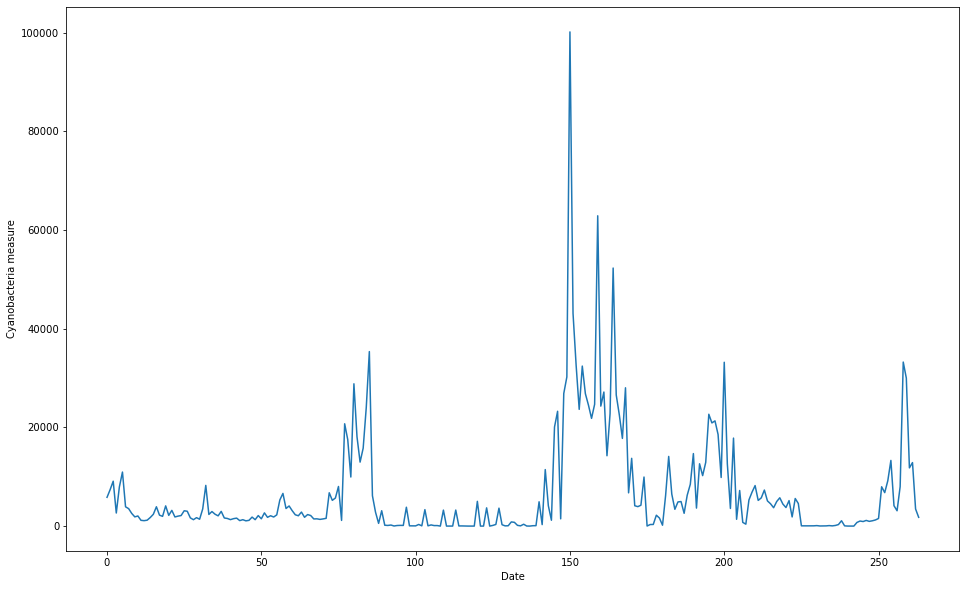

In [28]:
merged_locations_gt = merge_locations(dataset.algae_gt)
print(merged_locations_gt)
plt.figure(figsize=(16,10))
plt.plot(merged_locations_gt["fico"])
plt.xlabel('Date')
plt.ylabel('Cyanobacteria measure')
plt.show()